# Chapter 31- ING Entrainment of E - Cells
This notebook is a translation of an example in Christophe Borgers' book, "An Introduction to Modeling Neuronal Dynamics"

In this tutorial,we display an Interneuronal Network Gamma (ING) network entrain excitatory neurons (E-cells). Gamma rhythms are 30-80 Hz, thus the firing of the E-cells must be within this range. We model 400 E-cells with an RTM model and the ING cells with a WB model.

requirements:

 bmtk

 NEURON 7.4+

### Create nodes
The ING network, E-cells, and external input nodes are defined

In [1]:
! pip install -q h5py==2.9.0
! pip install -q bmtk==0.0.9
! pip install -q neuron==8.0.0
# as new version of neuron and bmtk come out we may need to install a specific version
import os
from os.path import normpath, sep, join

root = 'Borgers-Examples-in-BMTK' # name of github repo
folder = '31-ING_Entrainment' # name of folder in Github just change this line 
pathlist = normpath(os.getcwd()).split(sep)
if pathlist[-1] != folder:
  rootidx = pathlist.index(root) if root in pathlist else -1
  if rootidx>0:
    os.chdir(join(sep,*pathlist[:rootidx]))
  !git clone https://github.com/Kally367294/Borgers-Examples-in-BMTK
  os.chdir(join(root,folder))
print(os.getcwd())
%ls

     |████████████████████████████████| 2.8 MB 9.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
     |████████████████████████████████| 4.8 MB 9.4 MB/s 
     |████████████████████████████████| 12.6 MB 9.2 MB/s 
Cloning into 'Borgers-Examples-in-BMTK'...
remote: Enumerating objects: 859, done.
remote: Counting objects: 100% (859/859), done.
remote: Compressing objects: 100% (474/474), done.
remote: Total 859 (delta 453), reused 722 (delta 357), pack-reused 0
Receiving objects: 100% (859/859), 30.76 MiB | 26.99 MiB/s, done.
Resolving deltas: 100% (453/453), done.
/content/Borgers-Examples-in-BMTK/31-ING_Entrainment
'31 - ING.ipynb'   components/   input/


In [2]:
import os
print(os.system('nrnivmodl components/mechanisms')) # compile modfiles. Return 0 for success, 1 for failure.

0


In [3]:
import numpy as np
import logging
import math

from bmtk.builder.networks import NetworkBuilder

# E - Cells
n_E = 400

net = NetworkBuilder('network')
net.add_nodes(N=n_E, pop_name='Exc',     # N = number of excitatory cells
        model_type='biophysical',
        model_template='hoc:RTMExcCell', # RTMExcCell hoc definition
        morphology='blank.swc')

# ING network
n_I = 100

net.add_nodes(N=n_I, pop_name='ING',     # N = number of ING cells
        model_type='biophysical',
        model_template='hoc:WBInhCell', 
        morphology='blank.swc')

### Connection rules 

We add connections based on a probability defined below. To prevent autapses, if the node_id is equal between source and targe cell, no connection is made.

In [4]:
import random

def syn_connector(source,target,p):
    if source['node_id'] == target['node_id']:
        return 0
    return 1 if random.random() < p else 0

### Creating ING Edges

Probabilities and conductances are taken from chapter 31 of Borgers' book. Inhibitory connections between ING cells are added; Inhibitory connections from ING cells to E - cells are added; gap juctions between ING cells are added.

In [5]:
g_ee = 0
g_ei = 0
g_ie = 0.5  #0.5
g_ii = 0.5  #0.5
g_gap = 0.1

p_gap = 0.05
p_ee = 1
p_ei = 0.5
p_ie = 0.5  # 0.5
p_ii = 0.5   # 0.5



#E-E connections dont exist (g_ee = 0)
         
#E-I connections dont exist (g_ei = 0)

#I-I connections
net.add_edges(source={'pop_name':'ING'}, target={'pop_name':'ING'},
                    connection_rule=syn_connector, 
                    connection_params={'p':p_ii},
                    delay=0,
                    syn_weight = g_ii/n_I,
                    weight_function=None,
                    target_sections=['soma'],
                    distance_range=[0.0, 0.1],
                    dynamics_params='PING_InhToInh.json',
                    model_template='Exp2Syn')
                    
#I-E connections
net.add_edges(source={'pop_name':'ING'}, target={'pop_name':'Exc'},
                    connection_rule=syn_connector,
                    connection_params={'p':p_ie},
                    delay=0,
                    syn_weight = g_ie/n_I,
                    weight_function=None,
                    target_sections=['soma'],
                    distance_range=[0.0, 0.1],
                    dynamics_params='PING_InhToExc.json',
                    model_template='Exp2Syn')

#gap junctions
net.add_edges(source={'pop_name':'ING'}, target={'pop_name':'ING'}, 
                      syn_weight=g_gap,
                      weight_function=None,
                      target_sections=['soma'],
                      model_template='Gap',
                      delay=0,
                      distance_range=[0.0, 0.1],
                      is_gap_junction=True,
                      connection_rule=syn_connector, 
                      connection_params={'p':p_gap})

In [6]:
net.build()
net.save_nodes(output_dir='network')
net.save_edges(output_dir='network')

In [7]:
from bmtk.builder.networks import NetworkBuilder

extnet = NetworkBuilder('extnet')

extnet.add_nodes(N=n_E, model_type='virtual', pop_name='bgnoisevirtExt', pop_group='bgnoisevirtExt')

### Current Clamps for E-Cells and ING network

In [8]:
import h5py

I_bar_E = 1.5      #1.5
sigma_E = 0.1   #0.1
I_bar_I = 1.5      #1.5
sigma_I = 0.5   #0.5


n_I = 100
n_E = 400
sim_len = 500
dt = 1
samples = int(sim_len/dt)
amp = np.zeros((n_E+n_I,samples))


amp[n_I:,:] = (I_bar_E * (1 + sigma_E*np.random.normal(size=n_E))).reshape(-1,1) # Excitatory Cell Current Injection
amp[:n_I,:] = (I_bar_I * (1 + sigma_I*np.random.normal(size=n_I))).reshape(-1,1) # Inhibitory Cell Current Injection


dts = [1]
gids = "all"

#hf.close() # Uncomment this line temporarily if you receive 'file already open error'

hf = h5py.File("input/amps.h5", 'w')

hf.create_dataset("amplitudes", data=[amp])
hf.create_dataset("gids", data=gids)
hf.create_dataset("dts", data=dts)

hf.close()

### Set up Simulation Environment

In [9]:
from bmtk.utils.sim_setup import build_env_bionet

build_env_bionet(base_dir='.',
                 network_dir='network',
                 tstop=500.0, dt=0.1,
                 report_vars=['v'],           # Record membrane potential and calcium (default soma)
                 #spikes_inputs=[('extnet',   # Name of population which spikes will be generated for
                                #'input/ext_inp_poisson.h5')],
                 #file_current_clamp={              
                      #"input_type": "file_current_clamp",
                      #"module": "FileIClamp",
                      #"input_file":"input/amps.h5",
                      #"node_set":"all"
                 #},
                  current_clamp={            # Creates a step current from 500.ms to 1500.0 ms
                    'amp': 0.400,
                    'delay': 0,
                    'duration': 30.0
                  },
                 v_init= -65,
                 include_examples=False,    # Copies components files
                 compile_mechanisms=False,   # Will try to compile NEURON mechanisms
                 config_file ='config.json'
                )

### Run the Simulation

In [10]:
from bmtk.simulator import bionet


conf = bionet.Config.from_json('config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2022-04-11 20:24:42,393 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


NEURON mechanisms not found in /content/Borgers-Examples-in-BMTK/31-ING_Entrainment/components/mechanisms.
2022-04-11 20:24:42,509 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2022-04-11 20:24:43,163 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2022-04-11 20:25:28,392 [INFO] Running simulation for 500.000 ms with the time step 0.100 ms


INFO:NEURONIOUtils:Running simulation for 500.000 ms with the time step 0.100 ms


2022-04-11 20:25:28,401 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2022-04-11 20:25:28,405 [INFO] Block save every 5000 steps


INFO:NEURONIOUtils:Block save every 5000 steps


2022-04-11 20:26:40,228 [INFO]     step:5000 t_sim:500.00 ms


INFO:NEURONIOUtils:    step:5000 t_sim:500.00 ms


2022-04-11 20:26:40,313 [INFO] Simulation completed in 71.92 seconds 


INFO:NEURONIOUtils:Simulation completed in 71.92 seconds 


### Analyze Results

We did not add initial voltage values to the ING network nor the E - cells. Because of a synchronous initialization, only the ING cell entrainment of the E-cells can be observed. The E - cells are already synchronous.

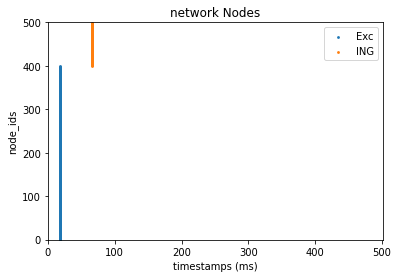

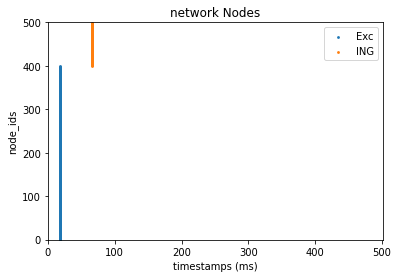

In [11]:
from bmtk.analyzer.spike_trains import plot_raster,plot_rates_boxplot

plot_raster(config_file='config.json', with_histogram=False, population='network', group_by='pop_name')

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


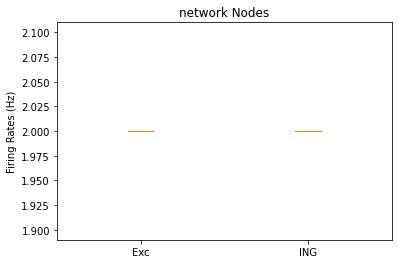

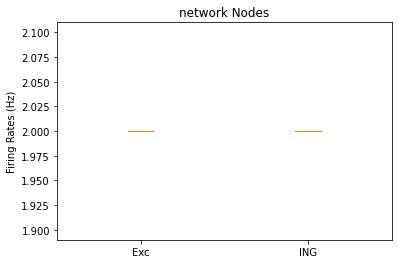

In [12]:
plot_rates_boxplot(config_file='config.json', group_by='pop_name')

The ING network successfully entrained the E-cells (Exc) at ~30 Hz which is in Gamma wave range